In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import re
import marimo as mo

In [2]:
base_dir = "/root/vllm/benchmarks/result"
replace_name = {
    "fcfs": "FCFS",
    "las": "LAS",
    "srjf": "SRJF",
    "sjf": "SJF",
    "tfittradeoff": "TFITTradeoff",
}

In [3]:
#  _date = "20240918"
# _date = "20241127"
_date = "20241202"
# _counters = [0,9,200,201,11]
# _counters = [63,64,65]
_counters= [63,64,70,71,72,74]
e2e_result_dir_names = [
    os.path.join(base_dir, _date, str(counter)) for counter in _counters
]

In [4]:
e2e_result_dfs = {}
for dir_name in e2e_result_dir_names:
    for file in os.listdir(dir_name):
        if file.endswith(".json"):
            # print(file)
            with open(os.path.join(dir_name, file), "r") as f:
                data = json.load(f)
            # print(data)
            e2e_result_df = pd.DataFrame(data)
            e2e_result_df.drop(
                columns=[
                    "date",
                    "backend",
                    "tokenizer_id",
                    "best_of",
                    "use_beam_search",
                ],
                inplace=True,
            )
            e2e_result_df.replace(
                replace_name,
                inplace=True,
            )
            e2e_result_dfs[file] = e2e_result_df

In [5]:
def add_num_annotation(ax, rotation=0, fontsize=10):
    for _p in ax.patches:
        if _p.get_height() == 0:
            continue
        ax.annotate(
            str(round(_p.get_height(), 2)),
            (_p.get_x() + _p.get_width() / 2.0, _p.get_height() * 1.05),
            ha="center",
            va="center",
            xytext=(0, 6),
            textcoords="offset points",
            rotation=rotation,
            fontsize=fontsize,
        )

In [6]:
def get_tp_ratio(df):
    print(df)
    min_result = df["output_throughput"].min()
    df["output_throughput"] = df["output_throughput"] / 1
    return df

In [7]:
def e2e_result(
    add_num_annotation,
    e2e_result_dfs,
    get_tp_ratio,
    pd,
    plt,
    sns,
):
    e2e_result = {
        "scheduling_policies": [],
        "swap_policies": [],
        "request_throughput": [],
        "output_throughput": [],
        "request_rates": [],
    }
    for _df_name in e2e_result_dfs:
        _tmp_df = e2e_result_dfs[_df_name]
        e2e_result["scheduling_policies"].append(
            _tmp_df["scheduler_policy"].iloc[0]
        )
        e2e_result["swap_policies"].append(_tmp_df["swap_policy"].iloc[0])
        e2e_result["request_throughput"].append(
            _tmp_df["request_throughput"].mean()
        )
        e2e_result["request_rates"].append(_tmp_df["request_rate"].iloc[0])
        e2e_result["output_throughput"].append(_tmp_df["output_throughput"].mean())

    _result_df = pd.DataFrame(e2e_result)

    _result_df = (
        _result_df.groupby(
            ["scheduling_policies", "swap_policies", "request_rates"]
        )
        .max()
        .reset_index()
    )
    _result_df = (
        _result_df.groupby(
            ["swap_policies", "request_rates"],
            group_keys=False,
        )
        .apply(lambda row: get_tp_ratio(row))
        .reset_index()
    )
    sns.set_style(style="whitegrid")
    sns.set_palette("deep")
    fig, axes = plt.subplots(
        2,
        1,
        figsize=(10, 4),
        dpi=150,
    )
    sns.barplot(
        data=_result_df,
        x="request_rates",
        y="request_throughput",
        hue="scheduling_policies",
        ax=axes[0],
        width=0.7
    )
    add_num_annotation(axes[0], rotation=90)
    axes[0].legend(
        title="",
        frameon=False,
        ncol=3,
        loc=(0, 1),
        handlelength=1.0,
        columnspacing=0.5,
    )
    axes[0].set_ylim(0, 2.0)
    axes[0].set_ylabel("Throughput (requests/s)")
    axes[0].set_xlabel("Request Rate (r/s)")
    axes[0].grid(linestyle="--", alpha=0.5, axis="y")
    sns.barplot(
        data=_result_df,
        x="request_rates",
        y="output_throughput",
        hue="scheduling_policies",
        legend=False,
        ax=axes[1],
        width=0.7,
    )
    add_num_annotation(axes[1], rotation=90)
    # axes[1].set_ylim(0, 600\
    axes[1].set_ylabel("Throughput (Token/s)")
    axes[1].set_xlabel("Request Rate (r/s)")
    axes[1].grid(linestyle="--", alpha=0.5, axis="y")
    plt.show()

In [8]:
selected_result = {
    "scheduler_policy": [],
    "swap_policy": [],
    "request_rate": [],
}
selected_columns = [
    "mean_ttft_ms",
    "median_ttft_ms",
    "p99_ttft_ms",
    "mean_tpot_ms",
    "median_tpot_ms",
    "p99_tpot_ms",
    "mean_itl_ms",
    "median_itl_ms",
    "p99_itl_ms",
    "mean_lat_ms",
    "median_lat_ms",
    "p99_lat_ms",
]
for _column in selected_columns:
    selected_result[_column] = []
for _df_name in e2e_result_dfs:
    tmp_df = e2e_result_dfs[_df_name]
    for _column in selected_result:
        if _column in tmp_df.columns:
            if isinstance(tmp_df[_column][0], float):
                selected_result[_column].append(tmp_df[_column].min())
            else:
                selected_result[_column].append(tmp_df[_column][0])

In [9]:
# def line_plot(_long_df):
#     (_fig, _axes) = plt.subplots(
#         figsize=(4 * 2, 2 * 2), dpi=150, nrows=2, ncols=2
#     )
#     _long_df = _long_df[_long_df["metric_name"] != "Median"]
#     metric_types = _long_df["metric_type"].unique().tolist()
#     metric_names = _long_df["metric_name"].unique().tolist()
#     scheduler_policies = _long_df["scheduler_policy"].unique().tolist()
#     _long_df["line_type"] = _long_df[
#         ["scheduler_policy", "metric_name"]
#     ].apply(
#         lambda row: row["scheduler_policy"] + " " + row["metric_name"], axis=1
#     )
#     line_styles = ["-", "--", "-.", ":","--"]
#     mark_styles = ["d", "o", "v"]
#     colors = ["r", "g", "b", "y","y"]
#     save_legend = True
#     for _i, metric_type in enumerate(metric_types):
#         _ax = _axes[_i // 2][_i % 2]
#         if _i > 0:
#             save_legend = False
#         data = _long_df[(_long_df["metric_type"] == metric_type)]

#         # 按 line_type 分组
#         grouped = data.groupby(["scheduler_policy", "metric_name"])
#         # # 遍历每个 line_type 并绘制线条
#         for name, group in grouped:
#             policy, metric = name
#             line_style = line_styles[scheduler_policies.index(policy)]
#             mark_style = mark_styles[metric_names.index(metric)]
#             color = colors[scheduler_policies.index(policy)]
#             _ax.plot(
#                 group["request_rate"],
#                 group["Ratio"],
#                 label=name,
#                 linestyle=line_style,
#                 marker=mark_style,
#                 color=color,
#             )

#         _ax.set_xlabel(metric_type)
#         _ax.set_ylabel("")
#         add_num_annotation(_ax, rotation=0)
#         _ax.grid(linestyle="--", alpha=0.5, axis="y")
#     _axes[0][0].legend(
#         title="",
#         frameon=False,
#         ncol=3,
#         loc=(0, 1),
#         handlelength=1.0,
#         columnspacing=0.5,
#     )

# def barplot(_long_df, request_rate):
#     (_fig, _ax) = plt.subplots(
#         figsize=(6 * 2, 1.5 * 2), dpi=150, nrows=2, ncols=2
#     )
#     metric_types = _long_df["metric_type"].unique().tolist()
#     metric_names = _long_df["metric_name"].unique().tolist()

#     _long_df = _long_df[_long_df["request_rate"] == request_rate]

#     save_legend = True
#     for metric_type in metric_types:
#         _i = metric_types.index(metric_type)
#         if _i > 0:
#             save_legend = False
#         ax = sns.barplot(
#             hue="scheduler_policy",
#             y="Ratio",
#             x="metric_name",
#             data=_long_df[_long_df["metric_type"] == metric_type],
#             ax=_ax[_i // 2][_i % 2],
#             legend=save_legend,
#             width=0.6
#         )
        
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
        
#         _ax[_i // 2][_i % 2].set_xlabel(metric_type)
#         _ax[_i // 2][_i % 2].set_ylabel("")
#         _ax[_i // 2][_i % 2].set_ylim(
#             0,
#             _long_df[_long_df["metric_type"] == metric_type]["Ratio"].max()
#             * 1.5,
#         )
#         add_num_annotation(_ax[_i // 2][_i % 2], rotation=0)
#         _ax[_i // 2][_i % 2].grid(linestyle="--", alpha=0.5, axis="y")

#         _ax[0][0].legend(
#             title="",
#             frameon=False,
#             ncol=3,
#             loc=(0, 1),
#             handlelength=1.0,
#             columnspacing=0.5,
#         )

In [10]:
def get_metric_ratio(df):
    min_result = df["Value"].min()
    df["Ratio"] = df["Value"] / min_result
    return df


_result_df = pd.DataFrame(selected_result)
_result_df = (
    _result_df.groupby(["scheduler_policy", "swap_policy", "request_rate"])
    .mean()
    .reset_index()
)
_long_df = _result_df[
    ["scheduler_policy", "swap_policy", "request_rate"] + selected_columns
]
_long_df = _long_df.melt(
    id_vars=["scheduler_policy", "swap_policy", "request_rate"],
    value_vars=selected_columns,
    var_name="Metric",
    value_name="Value",
)
_long_df = (
    _long_df.groupby(
        ["Metric", "request_rate"],
        group_keys=False,
    )
    .apply(lambda row: get_metric_ratio(row))
    .reset_index()
)

_long_df[["metric_name", "metric_type"]] = _long_df["Metric"].apply(
    lambda row: pd.Series(
        [row.split("_", 2)[0].capitalize(), row.split("_", 2)[1].upper()]
    )
)
# _long_df = _long_df[_long_df["metric_name"] == "P99"]



/tmp/ipykernel_5051/247932586.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda row: get_metric_ratio(row))


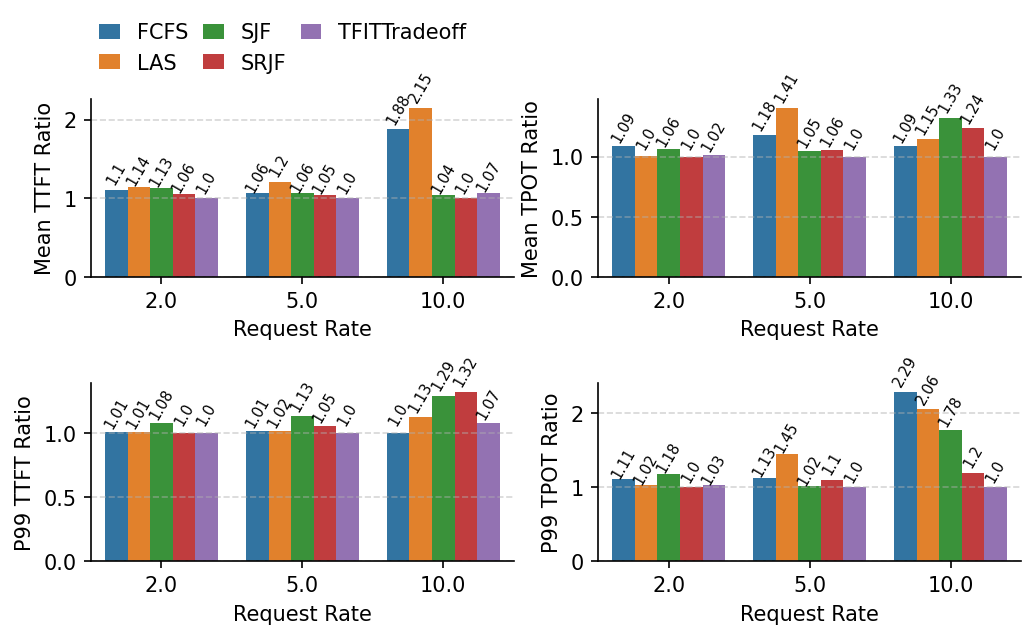

In [20]:
def bar_plot_1(_long_df, required_metric_name):
    (_fig, _ax) = plt.subplots(
        figsize=(4 * 2, 2 * 2), dpi=150, nrows=2, ncols=2
    )
    
    for metric_name in _long_df["metric_name"].unique().tolist():
        if required_metric_name != metric_name:
            _long_df = _long_df[_long_df["metric_name"] != metric_name]
    metric_types = _long_df["metric_type"].unique().tolist()
    metric_names = _long_df["metric_name"].unique().tolist()
    scheduler_policies = _long_df["scheduler_policy"].unique().tolist()

    save_legend = True
    for _i, metric_type in enumerate(metric_types):
        if _i > 0:
            save_legend = False

        data = _long_df[(_long_df["metric_type"] == metric_type)]

        ax = sns.barplot(
            x="request_rate",  
            y="Ratio",        
            hue="scheduler_policy",  
            data=data,
            ax=_ax[_i // 2][_i % 2]
        )
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        _ax[_i // 2][_i % 2].set_xlabel("Request Rate")
        # _ax[_i // 2][_i % 2].set_ylabel(_long_df["metric_name"].unique().tolist()[0] + " " + metric_type+" Ratio")

        add_num_annotation(_ax[_i // 2][_i % 2], rotation=60, fontsize=7)
        
        _ax[_i // 2][_i % 2].grid(linestyle="--", alpha=0.5, axis="y")
        
        if _i == 0:
            _ax[_i // 2][_i % 2].legend(
                title="",
                frameon=False,
                ncol=3,
                loc=(0, 1.1),
                
                
                handlelength=1.0,
                columnspacing=0.7,
            )
        else:
            _ax[_i // 2][_i % 2].legend().remove()

def bar_plot_2(_long_df,  required_metric_name_list, required_metric_type_list):
    (_fig, _ax) = plt.subplots(
        figsize=(4 * 2, 2*2), dpi=150, nrows=2, ncols=2
    )
    _long_df = _long_df[((_long_df['metric_name']==required_metric_name_list[0])
                    &(_long_df['metric_type']==required_metric_type_list[0]))|((_long_df['metric_name']==required_metric_name_list[0])
                    &(_long_df['metric_type']==required_metric_type_list[1]))|((_long_df['metric_name']==required_metric_name_list[1])
                    &(_long_df['metric_type']==required_metric_type_list[0]))|((_long_df['metric_name']==required_metric_name_list[1])
                    &(_long_df['metric_type']==required_metric_type_list[1]))]
    metric_types = _long_df["metric_type"].unique().tolist()
    metric_names = _long_df["metric_name"].unique().tolist()
    scheduler_policies = _long_df["scheduler_policy"].unique().tolist()
    metrics = [(required_metric_name_list[0],required_metric_type_list[0]),(required_metric_name_list[0],required_metric_type_list[1]),
               (required_metric_name_list[1],required_metric_type_list[0]),(required_metric_name_list[1],required_metric_type_list[1])]
    save_legend = True
    for _i, (metric_name,metric_type) in enumerate(metrics):
        if _i > 0:
            save_legend = False

        data = _long_df[(_long_df["metric_type"] == metric_type)&(_long_df["metric_name"] == metric_name)]
        ax = sns.barplot(
            x="request_rate",  
            y="Ratio",        
            hue="scheduler_policy",  
            data=data,
            ax=_ax[_i // 2][_i % 2]
        )
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        _ax[_i // 2][_i % 2].set_xlabel("Request Rate")
        _ax[_i // 2][_i % 2].set_ylabel(metrics[_i][0] + " " + metrics[_i][1]+" Ratio")

        add_num_annotation(_ax[_i // 2][_i % 2], rotation=60, fontsize=7)
        
        _ax[_i // 2][_i % 2].grid(linestyle="--", alpha=0.5, axis="y")
        
        if _i == 0:
            _ax[_i // 2][_i % 2].legend(
                title="",
                frameon=False,
                ncol=3,
                loc=(0, 1.1),
                
                
                handlelength=1.0,
                columnspacing=0.7,
            )
        else:
            _ax[_i // 2][_i % 2].legend().remove()

required_metric_name = "P99"
# bar_plot_1(_long_df, required_metric_name=required_metric_name)
required_metric_name_list = ['Mean', 'P99']
required_metric_type_list = ['TTFT', 'TPOT']
bar_plot_2(_long_df, required_metric_name_list, required_metric_type_list)
plt.subplots_adjust(wspace=0.2, hspace=0.6)
# plt.savefig(f"{required_metric_name}.pdf", format='pdf')
plt.show()

In [12]:
request_level_result = pd.DataFrame()
for _df_name in e2e_result_dfs:
    _tmp_df = e2e_result_dfs[_df_name].copy()
    _tmp_df["request_level_p99_itls"] = _tmp_df["itls"].apply(
        lambda row: 0 if len(row) == 0 else np.percentile(row, 99)
    )
    _tmp_df.drop(
        columns=[
            "model_id",
            "swap_space",
            "preemption_mode",
            "max_num_seqs",
            "swap_policy",
            "iter_theshold",
            "swap_out_partial_rate",
            "waiting_iter_base",
            "duration",
            "completed",
            "total_input_tokens",
            "total_output_tokens",
            "median_tpot_ms",
            "median_itl_ms",
            "median_lat_ms",
            "input_lens",
            "output_lens",
            "itls",
        ],
        inplace=True,
    )
    request_level_result = pd.concat([request_level_result, _tmp_df], axis=0)

/tmp/ipykernel_5051/2090706351.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda _df: _df["request_level_p99_itls"].quantile(0.99))
/tmp/ipykernel_5051/2090706351.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda row: get_p99_ratio(row))


Text(0, 0.5, 'P99 ITL')

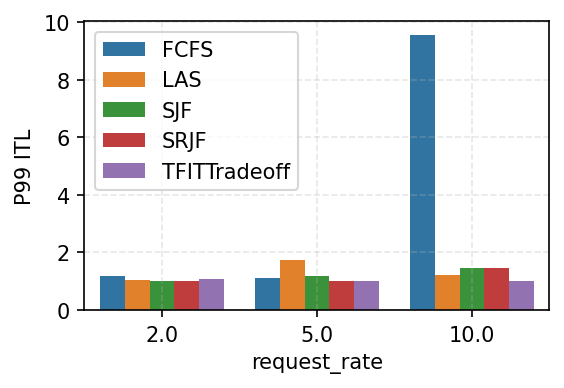

In [13]:
def get_p99_ratio(df):
    min_result = df["itls_p99"].min()
    df["itls_p99"] = df["itls_p99"] / min_result
    return df


_request_level_itls_p99_max = (
    request_level_result.groupby(["scheduler_policy", "request_rate"])
    .apply(lambda _df: _df["request_level_p99_itls"].quantile(0.99))
    .reset_index()
)
_request_level_itls_p99_max.columns = [
    "scheduler_policy",
    "request_rate",
    "itls_p99",
]
_request_level_itls_p99_max = (
    _request_level_itls_p99_max.groupby(
        ["request_rate"],
        group_keys=False,
    )
    .apply(lambda row: get_p99_ratio(row))
    .reset_index()
)
plt.figure(figsize=(4, 2.5), dpi=150)
sns.barplot(
    data=_request_level_itls_p99_max,
    x="request_rate",
    y="itls_p99",
    hue="scheduler_policy",
)
plt.legend(title="")
plt.grid(alpha=0.3, linestyle="--")
plt.ylabel("P99 ITL")

/tmp/ipykernel_5051/556890840.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda row: get_max_mean_ttft_ratio(row))


Text(0, 0.5, 'Median TTFT')

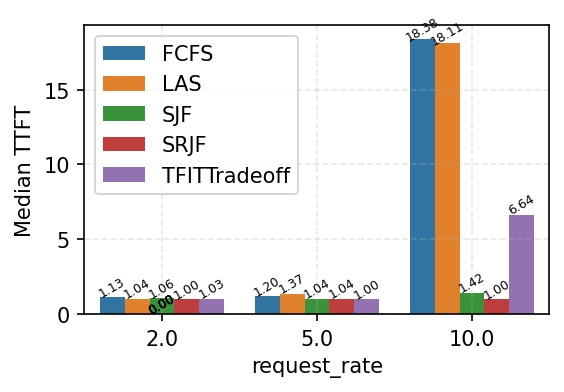

In [14]:
def get_max_mean_ttft_ratio(df):
    min_result = df["median_ttft_ms"].min()
    df["median_ttft_ms"] = df["median_ttft_ms"] / min_result
    return df


_request_level_mean_ttfts_max = (
    request_level_result.groupby(["scheduler_policy", "request_rate"])
    .agg({"median_ttft_ms": "median"})
    .reset_index()
)
_request_level_mean_ttfts_max.columns = [
    "scheduler_policy",
    "request_rate",
    "median_ttft_ms",
]
_request_level_mean_ttfts_max = (
    _request_level_mean_ttfts_max.groupby(
        ["request_rate"],
        group_keys=False,
    )
    .apply(lambda row: get_max_mean_ttft_ratio(row))
    .reset_index()
)
plt.figure(figsize=(4, 2.5), dpi=150)
ax = sns.barplot(
    data=_request_level_mean_ttfts_max,
    x="request_rate",
    y="median_ttft_ms",
    hue="scheduler_policy",
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        format(height, '.2f'),  # Format the number to two decimal places
        (p.get_x() + p.get_width() / 2., height),  # Position of the label
        ha='center',  # Horizontal alignment
        va='center',  # Vertical alignment
        xytext=(0, 5),  # Offset of the label
        textcoords='offset points',
        rotation=30,
        fontsize=6,
    )

plt.legend(title="")
plt.grid(alpha=0.3, linestyle="--")
plt.ylabel("Median TTFT")

In [15]:
_date = "20241202"
_counters = [65]
execute_result_dir_names = [
    os.path.join(base_dir, _date, str(counter)) for counter in _counters
]

In [16]:
# For Motivation
execute_result_dfs_moti = {}
for _dir_name in execute_result_dir_names:
    for _file in os.listdir(_dir_name):
        if (
            _file.endswith(".csv")
            and "_detailed" in _file
            and "5.0qps" in _file      # Need to change
        ):
            _detailed_result_df = pd.read_csv(os.path.join(_dir_name, _file))
            _detailed_result_df["gpu memory iter"] = (
                _detailed_result_df["gpu memory iter"]
            )
            print((_detailed_result_df["gpu memory iter"]).mean())
            print((_detailed_result_df["gpu computation iter"]).mean()/ 6900)
            _detailed_result_df["gpu computation iter"] = (
                _detailed_result_df["gpu computation iter"]
                / 6900
            )
            if "sjf" in _file:
                execute_result_dfs_moti["SJF"] = _detailed_result_df
            if "srjf" in _file:
                execute_result_dfs_moti["SRJF"] = _detailed_result_df
            elif "las" in _file:
                execute_result_dfs_moti["LAS"] = _detailed_result_df
            elif "fcfs" in _file:
                execute_result_dfs_moti["FCFS"] = _detailed_result_df
            elif "tfittradeoff" in _file:
                execute_result_dfs_moti["TFITTradeoff"] = _detailed_result_df

0.40539230117820324
0.010208906960363707
0.3370043861419442
0.008592014117394717
0.3861809740714786
0.009727308735260962
0.3526623864836325
0.008991220686735127
0.38998486381322955
0.009816315754397297


In [17]:
execute_result_dfs = {
    # "SJF": pd.DataFrame(),
    # "FCFS": pd.DataFrame(),
    # "TFITTradeoff": pd.DataFrame(),
}
for _dir_name in execute_result_dir_names:
    for _file in os.listdir(_dir_name):
        if (
            _file.endswith(".csv")
            and "_detailed" not in _file
            and "5.0qps" in _file      # Need to change
        ):
            _detailed_result_df = pd.read_csv(os.path.join(_dir_name, _file))
            _detailed_result_df["Cache Efficiency"] = (
                _detailed_result_df["Running"]
                / _detailed_result_df["GPU KV cache usage"]
            )
            if "sjf" in _file:
                # continue
                execute_result_dfs["SJF"] = _detailed_result_df
            elif "las" in _file:
                execute_result_dfs["LAS"] = _detailed_result_df
            elif "srjf" in _file:
                execute_result_dfs["SRJF"] = _detailed_result_df
            elif "fcfs" in _file:
                execute_result_dfs["FCFS"] = _detailed_result_df
            elif "tfittradeoff" in _file:
                execute_result_dfs["TFITTradeoff"] = _detailed_result_df

<Axes: title={'center': 'Cache Efficiency'}, xlabel='None', ylabel='Cache Efficiency'>

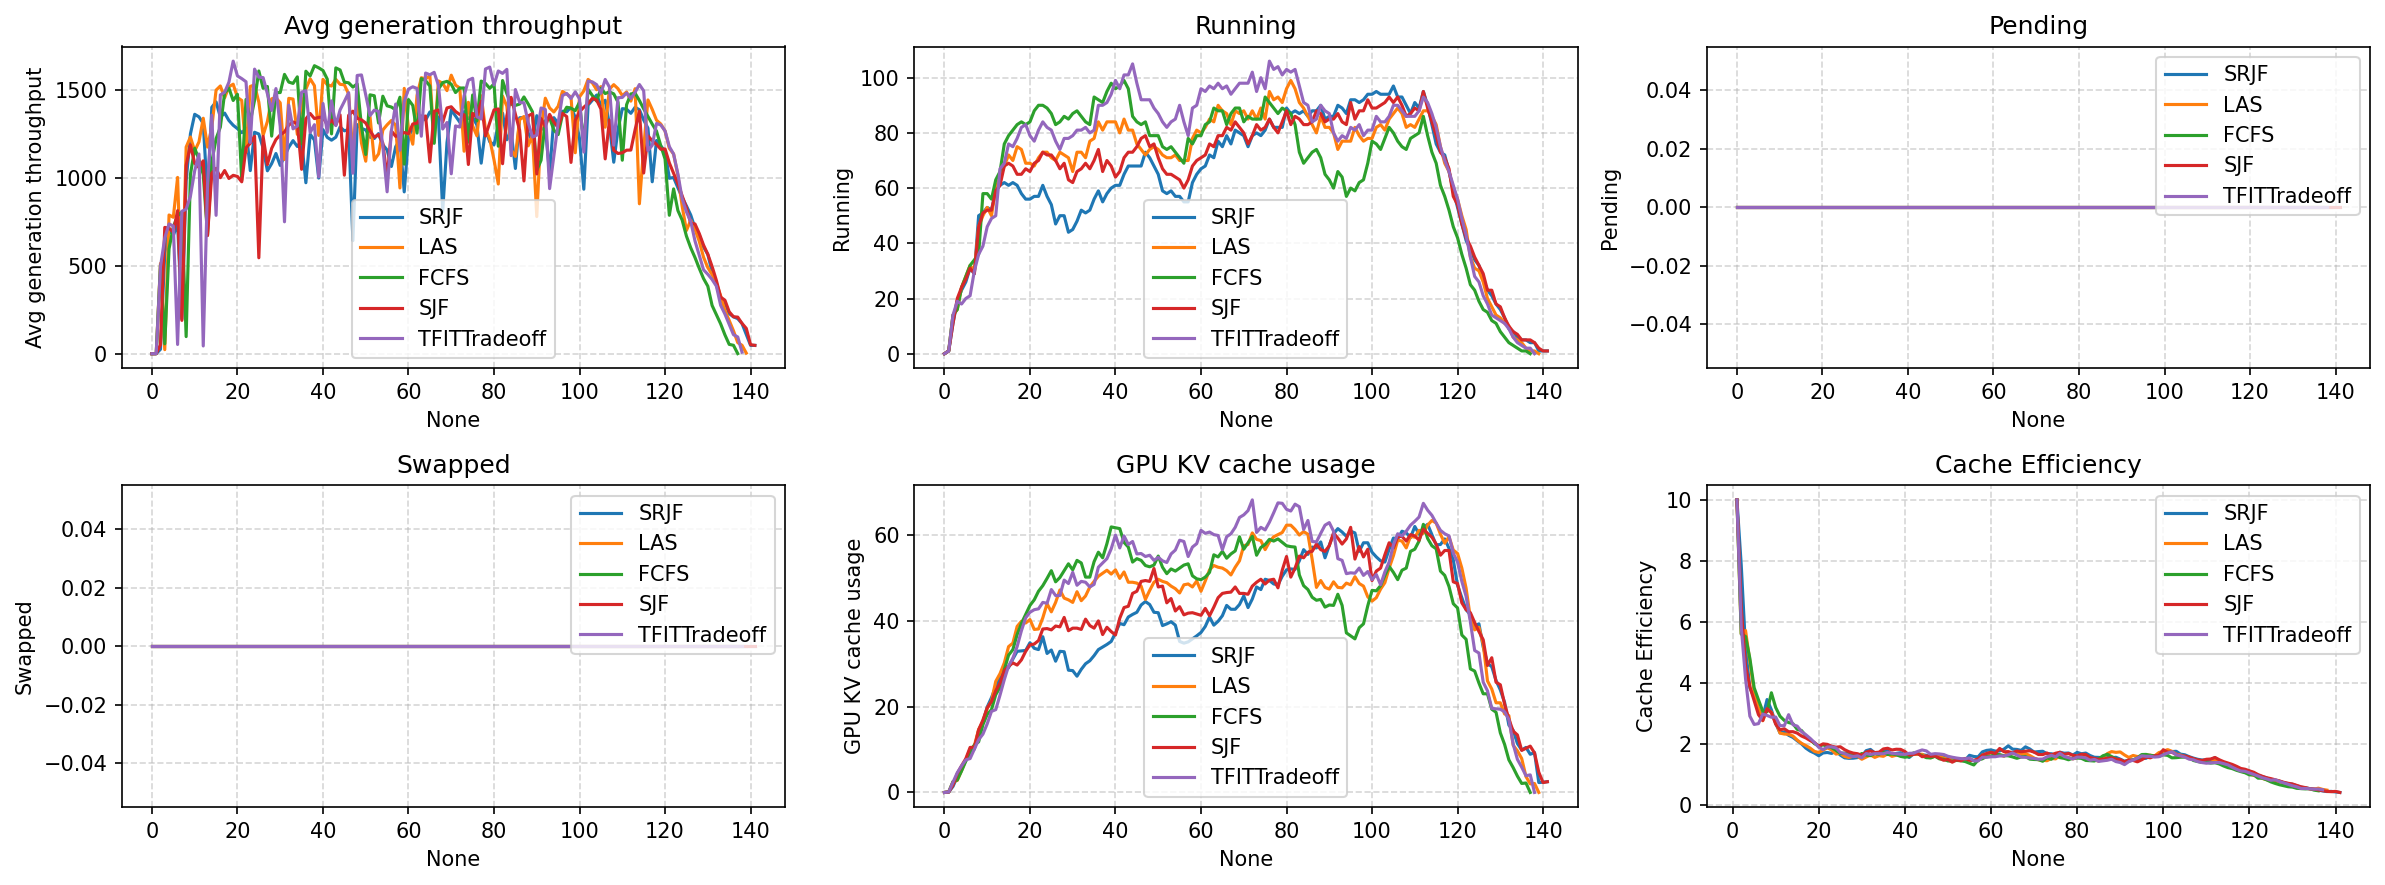

In [18]:
plt.figure(figsize=(16, 6), dpi=150)
# Subplot 1: Avg generation throughput
metric_labels = ["Avg generation throughput", "Running", "Pending", "Swapped", "GPU KV cache usage", "Cache Efficiency"]
policies = list(execute_result_dfs.keys())

for metric_label in metric_labels:
    plt.subplot(2, 3, metric_labels.index(metric_label)+1)
    plt.title(metric_label)
    plt.grid(alpha=0.5, linestyle="--")
    for policy in policies:
        sns.lineplot(
            data=execute_result_dfs[policy],
            x=execute_result_dfs[policy].index,
            y=metric_label,
            label=policy,
        )
plt.tight_layout()
plt.gca()